model:efficientnetB0

datasets:20 kinds of images collected manually 

1.  eggplant茄子
2.  carrot胡萝卜
3.  broccoli西兰花
4.  apple苹果
5.  strawberry草莓
6.  onion洋葱
7.  tomato西红柿
8.  mushroom香菇
9. avocado牛油果
10. banana香蕉
11. pineapple菠萝
12. durian榴莲
13. carambola杨桃
14. cashew腰果
15. tremella银耳
16. ginseng人参
17. cordyceps冬虫夏草
18. abalone鲍鱼
19. enoki金针菇
20. trepang海参

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pathlib
from tensorflow import keras
import efficientnet.tfkeras as efn

In [2]:
data_dir='D:/AI Projects/food-identification/ys_model/dataset/images'  #获取所有文件的目录

In [3]:
data_dir

'D:/AI Projects/food-identification/ys_model/dataset/images'

In [4]:
data_root=pathlib.Path(data_dir)

In [5]:
data_root  #获得路径对象

WindowsPath('D:/AI Projects/food-identification/ys_model/dataset/images')

In [6]:
all_image_paths = list(data_root.glob('*/*'))  #获得所有图片的路径

In [7]:
all_image_paths[0:3]

[WindowsPath('D:/AI Projects/food-identification/ys_model/dataset/images/人参/02b3037fd6a16d8d.jpg'),
 WindowsPath('D:/AI Projects/food-identification/ys_model/dataset/images/人参/03d81e0a0b34b012.jpg'),
 WindowsPath('D:/AI Projects/food-identification/ys_model/dataset/images/人参/047fc4d3823b9d91.jpg')]

In [8]:
image_count=len(all_image_paths)    #获取数量
image_count

8563

In [9]:
import random                        #random随机打乱这些顺序，防止训练时过拟合识别一种图片
all_image_paths=[str(i) for i in all_image_paths]   #先将路径转化为字符串
random.shuffle(all_image_paths)          #打乱

In [10]:
all_image_paths[1:3]

['D:\\AI Projects\\food-identification\\ys_model\\dataset\\images\\银耳\\cbc83e21ebffbac4.jpg',
 'D:\\AI Projects\\food-identification\\ys_model\\dataset\\images\\茄子\\QQ截图20210628104803_Convert.jpg']

In [11]:
path_label=set(i.split('\\')[-2] for i in all_image_paths)      #获得所有标签
path_label

{'人参',
 '冬虫夏草',
 '杨桃',
 '榴莲',
 '洋葱',
 '海参',
 '牛油果',
 '胡萝卜',
 '腰果',
 '苹果',
 '茄子',
 '草莓',
 '菠萝',
 '西兰花',
 '西红柿',
 '金针菇',
 '银耳',
 '香菇',
 '香蕉',
 '鲍鱼'}

In [12]:
label_to_index=dict((name, index) for index,name in enumerate(path_label))    #将标签对应数字  构造字典
label_to_index

{'冬虫夏草': 0,
 '菠萝': 1,
 '胡萝卜': 2,
 '草莓': 3,
 '香菇': 4,
 '鲍鱼': 5,
 '海参': 6,
 '洋葱': 7,
 '榴莲': 8,
 '西红柿': 9,
 '金针菇': 10,
 '牛油果': 11,
 '苹果': 12,
 '银耳': 13,
 '香蕉': 14,
 '人参': 15,
 '西兰花': 16,
 '腰果': 17,
 '茄子': 18,
 '杨桃': 19}

In [13]:
index_to_label={value:key for key,value in label_to_index.items()}
index_to_label

{0: '冬虫夏草',
 1: '菠萝',
 2: '胡萝卜',
 3: '草莓',
 4: '香菇',
 5: '鲍鱼',
 6: '海参',
 7: '洋葱',
 8: '榴莲',
 9: '西红柿',
 10: '金针菇',
 11: '牛油果',
 12: '苹果',
 13: '银耳',
 14: '香蕉',
 15: '人参',
 16: '西兰花',
 17: '腰果',
 18: '茄子',
 19: '杨桃'}

In [14]:
image_label=[label_to_index[path.split('\\')[-2]] for path in all_image_paths]   #将所有标签转化为数字存储
image_label[:5]

[2, 13, 18, 16, 13]

In [15]:
len(all_image_paths),len(image_label)

(8563, 8563)

In [16]:
def load_and_preprocess_image(path,label):   #图片标签处理函数
    image=tf.io.read_file(path)  #从path路径读取图片
    image=tf.image.decode_jpeg(image,channels=3)  #jpg解码 设置channel为3
    image=tf.image.resize(image, [260,260])   #将图片设置【x,y】大小 
    image = tf.image.random_flip_left_right(image)  #随机进行左右翻转
    #image = tf.image.random_flip_up_down(image)   
    image = tf.image.random_brightness(image, 0.5)  
    image=tf.cast(image, tf.float32)   #转化成训练时可使用的格式
    image=image/125.0-1           #将图像归一化处理  使像素点转化为[-1,1]之间，为了方便训练
    label = tf.reshape(label,[1])     #将label进行数组维度处理，提取他的值
    return image,label      

def load_preprocess_image_test(path,label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image,channels=3)
    image = tf.image.resize(image,[260,260])
    image = tf.cast(image,tf.float32)
    image = image/125.0-1
    label = tf.reshape(label,[1])
    return image,label

In [17]:
a=[[1]]
tf.reshape(a,[1])

<tf.Tensor: shape=(1,), dtype=int32, numpy=array([1])>

In [18]:
image_ds = tf.data.Dataset.from_tensor_slices((all_image_paths,image_label))   #切片处理 切成tensor类型的片成为使用的数据

In [19]:
image_ds

<TensorSliceDataset shapes: ((), ()), types: (tf.string, tf.int32)>

In [20]:
val_count=int(len(all_image_paths)*0.2)  #将百分之二十的数量作为测试数据
train_count=len(all_image_paths)-val_count   #剩下的作为训练数据

image_train_ds=image_ds.skip(val_count)   #训练数据
image_val_ds=image_ds.take(val_count)     #测试数据

In [21]:
val_count,train_count

(1712, 6851)

In [22]:
AUTOTUNE = tf.data.experimental.AUTOTUNE  #加速cpu读取配置
image_train_ds = image_train_ds.map(load_and_preprocess_image,num_parallel_calls=AUTOTUNE)   #训练数据使用训练数据处理函数处理
image_val_ds = image_val_ds.map(load_preprocess_image_test,num_parallel_calls=AUTOTUNE)

In [23]:
image_train_ds   #处理后的训练数据的类型表示

<ParallelMapDataset shapes: ((260, 260, 3), (1,)), types: (tf.float32, tf.int32)>

In [24]:
#训练
BATCH_SIZE = 12   #训练时每次提取12个图片 根据内存情况而定
image_train_ds = image_train_ds.repeat().shuffle(3000).batch(BATCH_SIZE)   #训练一次提取8张训练图片
image_train_ds = image_train_ds.prefetch(AUTOTUNE)
image_val_ds = image_val_ds.batch(BATCH_SIZE)
image_val_ds = image_val_ds.prefetch(AUTOTUNE)

In [25]:
covn_base = efn.EfficientNetB2(
               input_shape=(260,260,3), 
               weights='imagenet',
               include_top=False,
                pooling='avg')

In [26]:
covn_base.summary()

Model: "efficientnet-b2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 260, 260, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 130, 130, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 130, 130, 32) 128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 130, 130, 32) 0           stem_bn[0][0]                    
____________________________________________________________________________________

In [27]:
model = keras.Sequential()
model.add(covn_base)
model.add(keras.layers.Dense(512,activation='relu'))  #添加全连接层
model.add(tf.keras.layers.Dense(20, activation='softmax'))   #分类

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b2 (Functional) (None, 1408)              7768562   
_________________________________________________________________
dense (Dense)                (None, 512)               721408    
_________________________________________________________________
dense_1 (Dense)              (None, 20)                10260     
Total params: 8,500,230
Trainable params: 8,432,662
Non-trainable params: 67,568
_________________________________________________________________


In [29]:
covn_base.trainable = False   #将人家的这个层不可训练，单纯使用imagenet参数

In [30]:
model.compile(optimizer=keras.optimizers.Adam(lr=0.001),  #设置优化函数adam，目的是靠近极值点使得loss值越来越小  lr是调参的速率
             loss = 'sparse_categorical_crossentropy',     #loss值的定义方式
             #loss='binary_crossentropy',
              metrics=['acc'])    #准确率

In [31]:
history=model.fit(   #model.fit方法训练
    image_train_ds,   #训练数据
    steps_per_epoch=train_count//BATCH_SIZE,   #看每一次训练里 需要取多少次
    epochs=6,     #训练次数
    validation_data=image_val_ds,    #测试数据
    validation_steps=val_count//BATCH_SIZE   
)

Epoch 1/6
570/570 [==============================] - 139s 243ms/step - loss: 0.3031 - acc: 0.9108 - val_loss: 0.1321 - val_acc: 0.9619
Epoch 2/6
570/570 [==============================] - 103s 181ms/step - loss: 0.1078 - acc: 0.9629 - val_loss: 0.1158 - val_acc: 0.9671
Epoch 3/6
570/570 [==============================] - 129s 226ms/step - loss: 0.0627 - acc: 0.9789 - val_loss: 0.1126 - val_acc: 0.9654
Epoch 4/6
570/570 [==============================] - 105s 184ms/step - loss: 0.0516 - acc: 0.9823 - val_loss: 0.1285 - val_acc: 0.9660
Epoch 5/6
570/570 [==============================] - 105s 183ms/step - loss: 0.0431 - acc: 0.9858 - val_loss: 0.1552 - val_acc: 0.9613
Epoch 6/6
570/570 [==============================] - 83s 145ms/step - loss: 0.0404 - acc: 0.9870 - val_loss: 0.1272 - val_acc: 0.9683


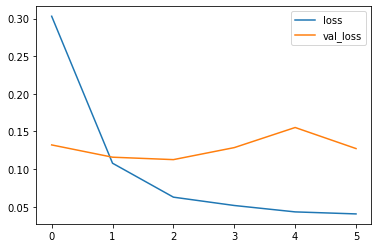

In [32]:
plt.plot(history.epoch,history.history.get('loss'),label='loss')
plt.plot(history.epoch,history.history.get('val_loss'),label='val_loss')
plt.legend()

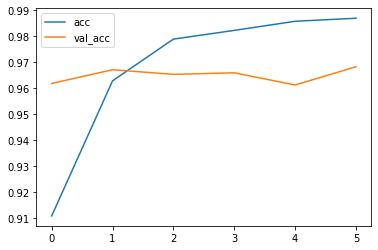

In [33]:
plt.plot(history.epoch,history.history.get('acc'),label='acc')
plt.plot(history.epoch,history.history.get('val_acc'),label='val_acc')
plt.legend()

In [34]:
covn_base.trainable=True
len(covn_base.layers)

333

In [35]:
fine_tune_at = -3
for layer in covn_base.layers[:fine_tune_at]:
    layer.trainable = False

In [36]:
model.compile(optimizer=keras.optimizers.Adam(0.0005),
             loss = 'sparse_categorical_crossentropy',
             metrics=['acc'])

In [37]:
initial_epochs=8
fine_tune_epochs=8
total_epoch = initial_epochs+fine_tune_epochs

history = model.fit(
    image_train_ds,
    steps_per_epoch=train_count//BATCH_SIZE,
    epochs=total_epoch,
    initial_epoch=initial_epochs,
    validation_data=image_val_ds,
    validation_steps=val_count//BATCH_SIZE
)

Epoch 9/16
570/570 [==============================] - 85s 149ms/step - loss: 0.0365 - acc: 0.9879 - val_loss: 0.1039 - val_acc: 0.9730
Epoch 10/16
570/570 [==============================] - 96s 169ms/step - loss: 0.0309 - acc: 0.9906 - val_loss: 0.1178 - val_acc: 0.9701
Epoch 11/16
570/570 [==============================] - 84s 147ms/step - loss: 0.0249 - acc: 0.9905 - val_loss: 0.1129 - val_acc: 0.9742
Epoch 12/16
570/570 [==============================] - 84s 148ms/step - loss: 0.0242 - acc: 0.9918 - val_loss: 0.1128 - val_acc: 0.9736
Epoch 13/16
570/570 [==============================] - 84s 147ms/step - loss: 0.0168 - acc: 0.9947 - val_loss: 0.1113 - val_acc: 0.9742
Epoch 14/16
570/570 [==============================] - 84s 147ms/step - loss: 0.0222 - acc: 0.9933 - val_loss: 0.1221 - val_acc: 0.9689
Epoch 15/16
570/570 [==============================] - 101s 176ms/step - loss: 0.0189 - acc: 0.9950 - val_loss: 0.1285 - val_acc: 0.9718
Epoch 16/16
570/570 [===========================

In [38]:
def load_preprocess_images(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image,channels=3)
    image = tf.image.resize(image,[260,260])
    image = tf.image.random_brightness(image,0.7)
    image = tf.cast(image,tf.float32)
    image = image/125.0-1
    return image

In [39]:
my_image = load_preprocess_images('D:/AI Projects/food-identification/ys_model/dataset/Training/牛油果/23_100.jpg')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


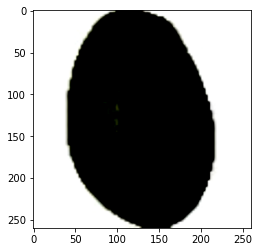

In [40]:
plt.imshow(my_image)

In [41]:
my_image = tf.expand_dims(my_image,0)   #增加第一个维度

In [42]:
pred = model.predict(my_image)   #假如分类为3   pred=[0.1,0.9,0.3]

In [44]:
print(index_to_label[np.argmax(pred)],':',pred[0][np.argmax(pred)])  #使用np.argmax取出最大的下标，也就是label对应的数

牛油果 : 0.9989711


In [45]:
model.save('D:/AI Projects/food-identification/ys_model/model/lk_ingredient_20.h5')